# Cohort-level Comparison of T2-w MRI Intensity Standardization Methods in Head and Neck Cancer for Quantitative Imaging Applications 

# Table of contents
1. [Introduction](#introduction)
2. [Dependencies](#dependencies)
    1. [Library Imports](#imports)
    2. [File Generation](#files)
3. [Main manuscript](#maintext)
    1. [Functions](#functions)
    2. [HOM Cohort](#HOM)
    3. [HET Cohort](#HET)
    4. [P-Value Heatmap](#pval)
4. [Supplementary Data](#appendix)
    1. [Additional Functions](#functions2)
    2. [T2-w histogram data](#T2)
    3. [T1-w Dixon Data (histograms, images, SD NMIc)](#T1)
    4. [CT Data (histograms, images, SD NMIc)](#CT)

# Introduction <a name="introduction"></a>

This is a notebook for the project "MRI Intensity Standardization Evaluation Design for Head and Neck Quantitative Imaging Applications" by the Fuller Lab at MD Anderson Cancer Center. An overview of the workflow is shown in the figure below. 

<img src="workflow.png" alt="workflow" height="100"> 

This notebook asssumes the .ipynb file is nested inside a folder containing the two cohort folders with a directory structure as such:

In [1]:
"""
Master_folder/
├── T2_Intensity_Standardization.ipynb
├── HET_cohort/
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2)
│         ├──DICOM files (modality.SOPUID.dcm)
│         ├──RT struct file (str.dcm)
├── HOM_cohort/
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2, CT, DIXON T1)*
│         ├──DICOM files (modality_slice.dcm)
│         ├──RT struct file (str.dcm)

* Note: CT and DIXON T1 images only avalaible for a subset of 5 patients
"""
;

The names and nested structure of the folders must adhere to this convention exactly or the scripts below will not work since this notebook uses relative file paths. The patient cohort folders containing anonymized DICOM files can be obtained from Figshare (https://figshare.com/s/116494bd42084eb691bc, doi: 10.6084/m9.figshare.13525481).

# Dependencies <a name="dependencies"></a>

## Library Imports <a name="imports"></a>

In [2]:
# importing neccessary libraries 

# system operations 
import os 
import sys
import shutil
import glob

# calculations
import numpy as np 
import pandas as pd
from math import floor

# plotting
import matplotlib.pyplot as plt 
from matplotlib.collections import QuadMesh
from matplotlib.text import Text
import seaborn as sns; sns.set(color_codes=True)

# stats
import pingouin as pg # pip install pingouin
from pingouin import pairwise_ttests

# image manipulation/processing
import SimpleITK as sitk # pip install SimpleITK
import nibabel as nib # pip install nibabel
import pydicom # pip install pydicom
from DicomRTTool.ReaderWriter import DicomReaderWriter # pip install DicomRTTool
from intensity_normalization.normalize import nyul # pip install git+git://github.com/jcreinhold/intensity-normalization.git

C:\Users\kawahid\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


The notebook should function properly as long as the following packages versions are installed: 
1. DicomRTTool version 0.3.21.
2. Intensity-normalization version 1.4.3.
3. Matplotlib version 3.3.2.
4. Nibabel version 3.1.0.
5. Numpy version 1.18.5 (required for Pyradiomics, newer version led to crashes).
6. Pandas version 1.1.3.
7. Pinguoin version 0.3.8.
8. Seaborn version 0.11.0.
9. SimpleITK version 1.2.4.

The notebook may possibly be run with newer versions of these libraries, but it is not gaurenteed. 

In [3]:
!pip list # list installed packages

Package                            Version
---------------------------------- -------------------
-tatsmodels                        0.12.0
absl-py                            0.12.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autograd                           1.3
autograd-gamma                     0.5.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.

## Neccessary File Generation <a name="files"></a>

Because this notebook is reliant on the histogram normalization method from Reinhold et al., which currently only works through input/output directories, we must first generate the required files. Lines of code below take approx. 20 mins to run. If the following lines of code have already been run (i.e. Nyul directories/files generated) they do not need to be rerun. Future iterations of this notebook may implement methods that have built in normalization instead of calls to path-based functions. The following lines of code will generate folders such that the new directory contents are:

In [4]:
"""
Master_folder/
├── T2_Intensity_Standardization.ipynb
├── HET_cohort/
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2)
│         ├──DICOM files (modality_slice.dcm)
│         ├──RT struct file (str.dcm)
├── HOM_cohort/
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2, CT, DIXON)
│         ├──DICOM files (modality.SOPUID.dcm)
│         ├──RT struct file (str.dcm)
├── HET_cohort_nyul/ <--- NEW
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2)
│         ├──nifti file (patient_hm.nii.gz)
├── HOM_cohort_nyul/ <--- NEW
│   ├──Patient folders (15 patients)
│      ├──Modality folders (T2, CT, DIXON)
│         ├──nifti file (patient_hm.nii.gz)
"""
;

entrypoints                        0.3
et-xmlfile                         1.0.1
fastcache                          1.1.0
filelock                           3.0.12
flake8                             3.8.4
Flask                              1.1.2
Flask-Compress                     1.10.1
formulaic                          0.2.4
fsspec                             0.8.3
future                             0.18.2
gdown                              3.13.0
gevent                             20.9.0
glob2                              0.7
graphviz                           0.17
greenlet                           0.4.17
h5py                               2.10.0
HeapDict                           1.0.1
hiddenlayer                        0.3
html5lib                           1.1
hyperopt                           0.2.5
idna                               2.10
ignite                             1.1.0
imageio                            2.9.0
imagesize                          1.2.0
imbalanced-learn   

''


numpydoc                           1.1.0
olefile                            0.46
opencv-python                      4.2.0.34
openpyxl                           3.0.5
osqp                               0.5.0
outdated                           0.2.1
packaging                          20.4
pandas                             1.1.3
pandas-flavor                      0.2.0
pandocfilters                      1.4.3
paramiko                           2.7.2
parso                              0.7.0
partd                              1.1.0
path                               15.0.0
pathlib2                           2.3.5
pathos                             0.2.8
pathtools                          0.1.2
patsy                              0.5.1
pep517                             0.10.0
pep8                               1.7.1
pexpect                            4.8.0
pickleshare                        0.7.5
Pillow                             8.0.1
pingouin                           0.3.8
pip         

In [5]:
def nyul_file_maker(cohort_path):
    """
    Generates a folder with images containing Nyul intensnity standardized nifti files from DICOM images in specific folder structure.
        Parameters:
            cohort_path (directory): Directory containing patients>modalities>DICOM files (images + structures).
        Returns:
            None (generates a folder that is used later in the notebook).
    """
    cohort = cohort_path.split('\\')[-1]
    main_path = os.path.dirname(cohort_path)
    export_path = os.path.join(main_path, cohort+'_nyul') 
    if cohort == "HOM_cohort":
        modality_list = ['CT', 'Dixon_F', 'T2'] # if you have any additional folders for modality add here 
    else:
        modality_list = ['T2']
    for modality in modality_list:
        for root, dirs, files in os.walk(cohort_path):
            for d in dirs: # look for the dirs, labeled with modality 
                if d.startswith(modality):
                    patient_path = os.path.join(root + '\\'+ d) # path to MRI modality for a given patient 
                    MRN = patient_path.split('\\')[-2] 
                    modality = patient_path.split('\\')[-1]

                    new_dir = os.path.join(export_path, MRN, modality)
                    if os.path.exists(new_dir):
                        shutil.rmtree(new_dir)
                    os.makedirs(new_dir)

                    Contour_Names = ['External_KW']
                    associations = {'External_KW(2)': 'External_KW'}
                    Dicom_reader = DicomReaderWriter(description='Examples', series_instances_dictionary = {})  # have to reset index every iteration 
                    Dicom_reader.walk_through_folders(patient_path)
                    Dicom_reader.set_contour_names_and_associations(Contour_Names=Contour_Names, associations=associations)
                    Dicom_reader.get_images_and_mask()
                    
                    dicom_sitk_handle = Dicom_reader.dicom_handle # SimpleITK image handle
                    mask_sitk_handle = Dicom_reader.annotation_handle # SimpleITK mask handle
                    sitk.WriteImage(dicom_sitk_handle, os.path.join(new_dir, MRN+'_image.nii.gz')) # make file
                    sitk.WriteImage(mask_sitk_handle, os.path.join(new_dir, MRN+'_mask.nii.gz'))

                    image_dir = os.path.join(export_path, 'image_dir')  
                    if os.path.exists(image_dir) == False:
                        os.makedirs(image_dir)
                    shutil.move(os.path.join(new_dir, MRN+'_image'+ '.nii.gz'), os.path.join(image_dir, MRN+'_image'+ '.nii.gz')) # now move the newly generated file into the dir 
                    mask_dir = os.path.join(export_path, 'mask_dir')
                    if os.path.exists(mask_dir) == False:
                        os.makedirs(mask_dir)
                    shutil.move(os.path.join(new_dir, MRN+'_mask'+ '.nii.gz'), os.path.join(mask_dir, MRN+'_mask'+ '.nii.gz')) # these need to be cleaner, less hard coded make paths above

        output_dir = os.path.join(export_path, 'output_dir') 
        nyul.nyul_normalize(img_dir = image_dir, mask_dir = mask_dir, output_dir = output_dir) # generate histogram normalized images

        for root, dirs, files in os.walk(export_path):
            for d in dirs: # look for the dirs, labeled with modality 
                if d.startswith(modality):
                    patient_path = os.path.join(root + '\\'+ d) # path to MRI modality for a given patient 
                    MRN = patient_path.split('\\')[-2]
                    modality = patient_path.split('\\')[-1]

                    for root, dirs, files in os.walk(output_dir): # move all the newly created nyul files 
                        for f in files:
                            path_to = os.path.join(root,f)
                            path_to_new = os.path.join(patient_path, f)
                            if f.split('_')[0] == MRN:
                                shutil.move(path_to, path_to_new)

        shutil.rmtree(image_dir) # remove the temporary directories and files 
        shutil.rmtree(mask_dir)
        shutil.rmtree(output_dir)

SimpleITK                          1.2.4
singledispatch                     3.4.0.3
six                                1.15.0
skope-rules                        1.0.1
slicer                             0.0.7
snowballstemmer                    2.0.0
sortedcollections                  1.2.1
sortedcontainers                   2.2.2
soupsieve                          2.0.1
Sphinx                             3.2.1
sphinxcontrib-applehelp            1.0.2
sphinxcontrib-devhelp              1.0.2
sphinxcontrib-htmlhelp             1.0.3
sphinxcontrib-jsmath               1.0.1
sphinxcontrib-qthelp               1.0.3
sphinxcontrib-serializinghtml      1.1.4
sphinxcontrib-websupport           1.2.4
spyder                             4.1.5
spyder-kernels                     1.9.4
SQLAlchemy                         1.3.20
staple                             0.3.2
statsmodels                        0.12.2
Surface-Distance-Based-Measures    0.1
sympy                              1.6.2
tables       

In [6]:
%%time
%%capture
HET_cohort_path = os.path.join('.', 'HET_cohort') 
nyul_file_maker(HET_cohort_path)

Wall time: 4min 48s


In [7]:
%%time 
%%capture
HOM_cohort_path = os.path.join('.', 'HOM_cohort') 
nyul_file_maker(HOM_cohort_path)

Wall time: 19min 31s


# Main Manuscript <a name="maintext"></a>

## Functions <a name="functions"></a> 

In [8]:
def dicom_to_numpy(ROI_list, path, modality):
    """
    Loads DICOM image and RT struct files into numpy arrays based on regions of interest. 
        Parameters:
            ROI_list (lst): List of ROIs that you want to use for analysis.
            path (directory): Path to cohort of interest (HET or HOM).
            modality (str): Type of image (CT, T2, DIXON, any additional).
        Returns:
            tuple_list_2 ((str,int,str)): List of tuples corresponding to pairs of ROI names, ROI indexes, and ROI categories.
            fat_left_index (int): Index corresponding to cheek fat left, to be used in Fat standardization method.
            fat_right_index (int): Index corresponding to cheek fat right, to be used in Fat standardization method.
            external_index (int): Index corresponding to external mask of head and neck, to be used in Z-External standardization method.
            df_image (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of image, patient identifier, and modality
            df_mask (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of mask, patient identifier, and modality
    """
    extension_list = ['_KW', '_KW(2)', '_KW(3)', '_KW(4)', '_SM'] # messy but neccessary since some structure files have different suffixes
    
    associations = {roi+extension:roi for roi in ROI_list for extension in extension_list}
    pair_list = [pair for pair in enumerate(ROI_list, start=1)] # list of tuples corresponding to ROI name and ROI index 
    tuple_list = [pair+('CSF',) if 'CSF' in pair[1] else pair+('Fat',) if 'Fat' in pair[1]
             else pair+('Other',) if 'Cerebellum' in pair[1] or 'Skull' in pair[1] or 'Parotid' in pair[1] else pair+('Muscle',) 
             for pair in pair_list] # this assigns a third value to characterize what this item is (for graphing purposes) added parotid for t1
    tuple_list_2 = [tup for tup in tuple_list if tup[1] != 'External'] # do not want to iterate through external
    
    df_image = pd.DataFrame(columns=['Modality','MRN', 'image_array'])
    df_mask = pd.DataFrame(columns=['Modality','MRN', 'mask_array'])
    counter = -1

    startswith = modality

    for root, dirs, files in os.walk(path): # path points to Master->MRN->timepoint->modality
        for d in dirs: # look for the dirs, labeled with modality 
            if d.startswith(startswith):
                counter+=1
                patient_path = os.path.join(root + '\\'+ d) # path to modality for a given patient 

                MRN = patient_path.split('\\')[-2]
                modality = patient_path.split('\\')[-1]

                Contour_Names = ROI_list
                associations = associations
                Dicom_reader = DicomReaderWriter(description='Examples', series_instances_dictionary = {})
                Dicom_reader.walk_through_folders(patient_path)
                Dicom_reader.set_contour_names_and_associations(Contour_Names=Contour_Names, associations=associations) 
                Dicom_reader.get_images_and_mask()
                
                image = Dicom_reader.ArrayDicom # image array
                mask = Dicom_reader.mask # mask array
                if modality == "CT":
                    image = image.astype(np.int16) # need for CT since negative HU
                else:
                    image = image.astype(np.uint16) #converting to more efficient data form 
                mask = mask.astype(np.uint8)

                df_image.loc[counter] = [modality, MRN, image] # add to dataframe here  
                df_mask.loc[counter] = [modality, MRN, mask]  
    
    pair_dict = dict([reversed(pair) for pair in pair_list])
    
    fat_left_index = pair_dict.get('Fat_L')
    fat_right_index = pair_dict.get('Fat_R')
    external_index = pair_dict.get('External')
    
    return tuple_list_2, fat_left_index, fat_right_index, external_index, df_image, df_mask 

In [9]:
def dicom_header_info(path, modality):
    """
    Creates a table of DICOM header information for a given cohort for a given modality. 
        Parameters:
            path (directory): Path to cohort of interest (HET or HOM).
            modality (str): Modality to be used (e.g. T2, CT, Dixon_F).
        Returns:
            df_dicom (pd dataframe): Dataframe with DICOM header information that acts as a table. 
    """
    if modality == "T2":
        header_list = ["SeriesDescription", "Manufacturer", "ManufacturerModelName",
                       "MagneticFieldStrength", "RepetitionTime", "EchoTime", "EchoTrainLength", "FlipAngle", "PixelSpacing",
                       "SliceThickness", "SpacingBetweenSlices", "ImagingFrequency", "NumberOfAverages", "PercentSampling", #"PixelBandwidth", # had to remove pixel bandwidth for one of the patients 
                       "AcquisitionMatrix", "PixelRepresentation",
                      ]
    elif modality == "Dixon_F": # no spacing between slices for some reason 
        header_list = ["SeriesDescription", "Manufacturer", "ManufacturerModelName",
                       "MagneticFieldStrength", "RepetitionTime", "EchoTime", "EchoTrainLength", "FlipAngle", "PixelSpacing",
                       "SliceThickness", "ImagingFrequency", "NumberOfAverages", "PercentSampling", "PixelBandwidth", 
                       "AcquisitionMatrix", "PixelRepresentation",
                      ]  
    elif modality == "CT":
        header_list = [ "SeriesDescription", "Manufacturer", "ManufacturerModelName",
                       "PixelSpacing", "SliceThickness", "Rows", "Columns", "KVP", "ConvolutionKernel",
                      ]
        
    df_dicom = pd.DataFrame(columns = header_list)

    counter = -1
    for root, dirs, files in os.walk(path):
        for d in dirs: # look for the dirs, labeled with modality 
            if d.startswith(modality):
                patient_path = os.path.join(root + '\\'+ d) # path to modality for a given patient 
                for root2, dirs2, files2 in os.walk(patient_path):
                    for file in files2:
                        f = pydicom.dcmread(os.path.join(root2,file))
                        if 'str' not in file and file.endswith('.dcm'):
                            counter+=1
                            df_dicom.loc[counter] = [getattr(f, x) for x in header_list] # get the value from the header 
                            break # only look at the first DICOM image file in the folder then exit the loop 

    return df_dicom  

In [10]:
def convert_array(array, index):
    """
    Creates a masked array specific for a given ROI index. 
        Parameters:
            array (np array): Input array corresponding to all masks superimposed on image.
            index (int): Index to mask with respect to, i.e. only select cetain sub-mask.
        Returns:
            array_new (np array): Output masked array.
    """
    array_new = array.copy() # must create copy or else changes original 
    array_new[array_new!=index] = 0
    array_new[array_new==index] = 1
    return array_new

def min_max_norm(image): 
    """
    Standardizes voxel intensities by rescaling to [0,1] range. 
        Parameters:
            image (np array): nxnxn array corresponding to image. 
        Returns:
            new_image (np array): nxnxn array corresponding to image after intensity standardization. 
    """
    minimum = np.amin(image)
    maximum = np.amax(image)
    new_image = np.divide((image - minimum),(maximum-minimum))
    return new_image

def z_norm(image):
    """
    Standardizes voxel intensities with respect to voxel intensities all voxels in image. 
        Parameters:
            image (np array): nxnxn array corresponding to image. 
        Returns:
            new_image (np array): nxnxn array corresponding to image after intensity standardization. 
    """
    mean = np.mean(image)
    std = np.std(image)
    new_image = np.divide((image - mean), std)
    return new_image
    
def z_norm_external(image, mask, index):
    """
    Standardizes voxel intensities with respect to voxel intensities in head and neck external mask ROI. 
        Parameters:
            image (np array): nxnxn array corresponding to image. 
            mask (np array): Mask overlayed on image corresponding to all masks superimposed on image. 
            index (int): Index corresponding to external mask ROI.
        Returns:
            new_image (np array): nxnxn array corresponding to image after intensity standardization. 
    """
    external_mask = convert_array(mask, index)
    external_mask = np.multiply(external_mask, image)
    external_mask_no0 = external_mask[external_mask > 0]
    mean = np.mean(external_mask_no0)
    std = np.std(external_mask_no0)
    new_image = np.divide((image - mean), std)
    return new_image

def fat_norm(image, mask, modality, index1, index2): 
    """
    Standardizes voxel intensities with respect to voxel intensities in left and right cheek fat ROIs. 
        Parameters:
            image (np array): nxnxn array corresponding to image. 
            mask (np array): Mask overlayed on image corresponding to all masks superimposed on image. 
            modality (str): Modality to be used (e.g. T2, CT, DIXON).
            index1 (int): Index corresponding to cheek fat left.
            index2 (int): Index corresponding to cheek fat right.
        Returns:
            new_image (np array): nxnxn array corresponding to image after intensity standardization. 
    """
    fat_l_mask = convert_array(mask, index1) # need to know index
    fat_l_mask = np.multiply(fat_l_mask,image) # superimpose mask on image to get real values in that area
    fat_r_mask = convert_array(mask, index2) 
    fat_r_mask = np.multiply(fat_r_mask,image) 
    if modality == "CT":
        fat_l_mask_no0 = fat_l_mask[fat_l_mask > -500] # HU
        fat_r_mask_no0 = fat_r_mask[fat_r_mask > -500]
    else:
        fat_l_mask_no0 = fat_l_mask[fat_l_mask > 0] # assume 0 floor
        fat_r_mask_no0 = fat_r_mask[fat_r_mask > 0]
    fat_l_mean = np.mean(fat_l_mask_no0)
    fat_r_mean = np.mean(fat_r_mask_no0)
    mean = np.mean([fat_l_mean,fat_r_mean])
    new_image = np.divide(image,mean)
    new_image = new_image*350
    return new_image
    
def histo_norm(path, MRN, modality): 
    """
    Standardizes voxel intensities with using Nyul and Udupa method of histogram intensity standardization. 
        Parameters:
            path (directory): Path to images already intensity standardized using histogram method from scripts above. 
            MRN (int): Patient identifier (anonymized).
            modality (str): Modality to be used (e.g. T2, CT, DIXON).
        Returns:
            image (np array): nxnxn array corresponding to re-oriented image loaded from directory. 
    """
    nyul_path = os.path.join(path, MRN, modality)
    f = os.listdir(nyul_path)[0] 
    nifti = nib.load(os.path.join(nyul_path,f))
    image = np.array(nifti.dataobj)
    image = np.moveaxis(image,-1,0) # have to swap axis because nyul scripts orient patient differently 
    image = np.swapaxes(image, 1, 2)
    return image

In [11]:
def standardization(method_list, df_image, df_mask, fat_left_index, fat_right_index, external_index, path2=None): 
    """
    Standardizes numpy array representations of images using previously defined intensity standardization functions and 
    loads them all into a pandas dataframe for ease of access. 
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            df_image (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of image, patient identifier, and modality.
            df_mask (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of mask, patient identifier, and modality.
            fat_left_index (int): Index corresponding to cheek fat left, to be used in Fat standardization method.
            fat_right_index (int): Index corresponding to cheek fat right, to be used in Fat standardization method.
            external_index (int): Index corresponding to external mask of head and neck, to be used in Z-External standardization method.
            path2 (directory): Path to Nyul itennsity standardized images, set to None by default so will not run Nyul method unless specified.  
        Returns:
            df_image_new (pd dataframe): Dataframe with rows corresponding to np arrays of unique patient method combinations. 
    """
    counter = -1 
    df_image_new = pd.DataFrame(columns=['Modality','MRN', 'Normalization', 'image_array'])
    method_list = method_list.copy()
    for modality, MRN, image, mask in zip(df_image['Modality'], df_image['MRN'], df_image['image_array'], df_mask['mask_array']):
        for method in method_list:
            counter+=1
            if method == "Original":
                new_image = image
            elif method == "Fat":
                new_image = fat_norm(image, mask, modality, fat_left_index, fat_right_index).astype('float32') # can try float16 if need more ram
            elif method == "Z-All":
                new_image = z_norm(image).astype('float32')
            elif method == "Z-External":
                new_image = z_norm_external(image, mask, external_index).astype('float32')
            elif method == "Nyul":
                new_image = histo_norm(path2, MRN, modality).astype('float32')
            elif method == "MinMax":
                new_image = min_max_norm(image).astype('float32')
            df_image_new.loc[counter] = [modality, MRN, method, new_image] # add to dataframe here
    return df_image_new
    
    

In [12]:
def plot_paper_images(method_list, df_image_new, cohort):
    """
    Generates images for manuscript, 5x5 plot with patient example images on x axis and standardization methods on y axis. Based
    on specific pre-defined slice locations for best visualization of middle areas of head. 
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            df_image_new (pd dataframe): Dataframe with rows corresponding to np arrays of unique patient method combinations. 
            cohort (str): "HET" or "HOM" cohort. 
        Returns:
            None (generates in-line plots of display images).
    """
    
    MRN_subset = ["1", "2", "3", "4", "5"] # only plot these 5 patient IDs
    df_image_new = df_image_new[df_image_new['MRN'].isin(MRN_subset)] # get df with the IDs above 
    
    method_list = method_list.copy()
    patient_num = 5
    if cohort == "HET":
        loc1, loc2, loc3, loc4, loc5 = 5, 7, 8, 5, 6 # locations were manually determined 
    elif cohort == "HOM":
        loc1, loc2, loc3, loc4, loc5 = 7, 5, 6, 8, 6
        
    n2 = -1
    fig, ax = plt.subplots(len(method_list), patient_num, figsize=[patient_num*2,len(method_list)*2], dpi=300, gridspec_kw = {'wspace':0, 'hspace':0})
    for method in method_list:
        n2+=1
        df_new = df_image_new.loc[df_image_new['Normalization'] == method]
        image_list = [image for image in df_new['image_array']] 
        image_list_flatten = [image.flatten() for image in image_list]
        all_images = np.concatenate(image_list_flatten)
        all_min = np.amin(all_images)
        all_max = np.amax(all_images)
        all_max_percentile = np.percentile(all_images,98)
        counter = -1
        for image in image_list:
            counter+=1
            image = np.moveaxis(image,0,-1)
            n = 0
            slice = 0
            total_slices = image.shape[2]
            for _ in range(13):
                n+=1
                if n == 12: # neccessary to get the last slice for 120 slices
                    slice+=(total_slices/12)-1
                else:
                    slice+=(total_slices/12) 
                if (counter == 0 and n == loc1) or (counter == 1 and n == loc2) or (counter == 2 and n == loc3) or (counter == 3 and n == loc4) or (counter == 4 and n == loc5):
                    ax[n2][counter].imshow(image[:,:,floor(slice)], 'gray', vmin = all_min, vmax = all_max_percentile) # added floor
                    ax[n2][counter].set_aspect("equal")
                    ax[n2][counter].set_xticks([])
                    ax[n2][counter].set_yticks([])
                    if counter == 0:
                        ax[n2][counter].set_ylabel(method)
                    if n2 == 0:
                        ax[n2][counter].set_xlabel("Patient " +str(counter+1))
                        ax[n2][counter].xaxis.set_label_position('top') 
                    fig.subplots_adjust(wspace=0, hspace=0)
                fig.subplots_adjust(wspace=0, hspace=0)
    fig.text(0.5, 0.92, 'Patient in Cohort', ha='center')  
    fig.text(0.04, 0.5, 'Intensity Standardization Method', va='center', rotation='vertical')
    plt.show()

<div>
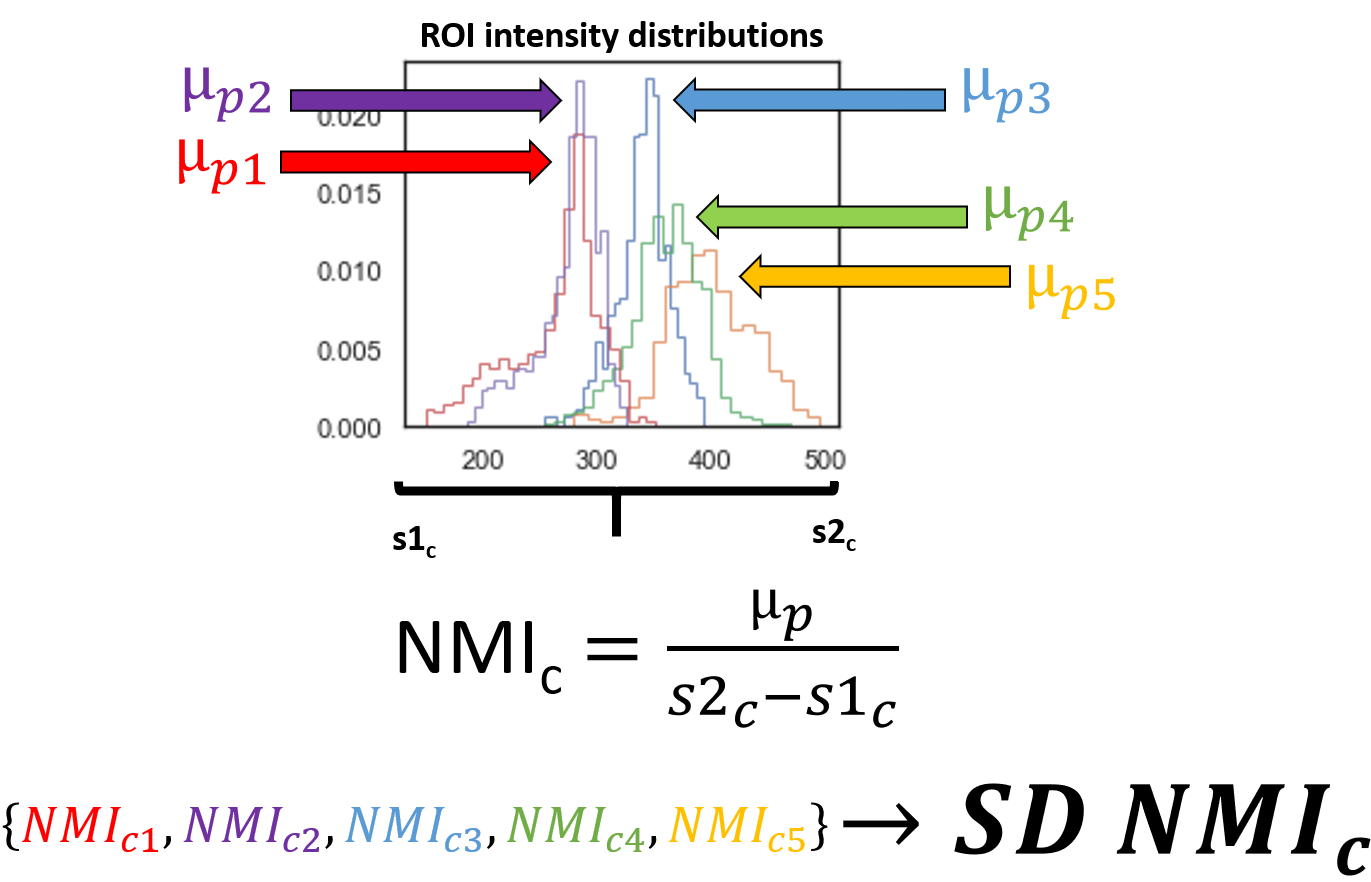
</div>

SD NMIc quantifies ROI histogram overlap. The variability of mean values across various distributions in a cohort calculated on a normalized scale gives a scale-invariant measure of standardization quality. 

In [13]:
def SDNMI_calc(method_list, tuple_list_2, df_image_new, df_mask):
    """
    Calculates SDNMIc for each ROI for each patient in a given cohort. 
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            tuple_list_2 ((str,int,str)): List of tuples corresponding to pairs of ROI names, ROI indexes, and ROI categories.
            df_image_new (pd dataframe): Dataframe with rows corresponding to np arrays of unique patient method combinations. 
            df_mask (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of mask, patient identifier, and modality.
        Returns:
            df2 (pd dataframe): Dataframe with rows corresponding to SDNMIc scores of unique combinations of ROIs, patients, and standardization methods.
    """
    
    method_list = method_list.copy()
    df2 = pd.DataFrame(columns=['Modality','ROI', 'Method', 'NMI', "SD_NMI", "COV_NMI", "COV_ALL", 'SD_mean_raw'])
    counter = -1  
    
    for method in method_list:
        for tup in tuple_list_2:
            index = tup[0]
            roi = tup[1]
            counter +=1
            NMI_list = [] # used for calculating the SD of the NMI for each region of interest 
            array_list = [] # can iterativley store here 
            mean_list = []
            df_new = df_image_new.loc[df_image_new['Normalization'] == method]
            for modality, MRN, image, mask in zip(df_new['Modality'], df_new['MRN'], df_new['image_array'], df_mask['mask_array']):
                image = image + 10000 # accounting for 0's in CT # dont need for zed score I think?
                mask = convert_array(mask, index)
                mask_superimposed = np.multiply(mask,image)
                mask_superimposed[mask_superimposed==0] = 20000
                mask_superimposed[mask_superimposed!= 20000] -= 10000 # accounting for 0's in CT
                mask_superimposed_no0 = mask_superimposed[mask_superimposed != 20000] # purley for plotting purposes, had to do to plot 0's for CT

                array_list.append(mask_superimposed_no0)
                mean_list.append(np.mean(mask_superimposed_no0))  

            all_arrays = np.concatenate(array_list) # concatenate

            for array in array_list:
                NMI = np.mean(array)/((np.percentile(all_arrays,98))-(np.percentile(all_arrays,2))) 
                NMI_list.append(NMI)

            sd_NMI = np.std(NMI_list) #sd of NMI
            cov_NMI = np.divide(np.std(NMI_list), abs(np.mean(NMI_list))) # coefficient of variation of NMI
            sd_mean = np.std(mean_list)
            cov_all = np.divide(np.std(all_arrays), abs(np.mean(all_arrays))) # coefficient of variation of all histograms

            df2.loc[counter] = [modality, roi, method, NMI_list, sd_NMI, cov_NMI, cov_all, sd_mean] # add to dataframe here
            
    return df2 

In [14]:
def SDNMI_heatmap(method_list, tuple_list_2, df2):
    """
    Generates a heatmap of SDNMIc scores per ROI per standardization method. 
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            tuple_list_2 ((str,int,str)): List of tuples corresponding to pairs of ROI names, ROI indexes, and ROI categories.
            df2 (pd dataframe): Dataframe with rows corresponding to SDNMIc scores of unique combinations of ROIs, patients, and standardization methods.
        Returns:
            None (generates in-line plot and prints mean ± SD for each method).
    """
    column_list = [tup[1] for tup in tuple_list_2]
    
    method_list = method_list.copy() # to prevent index problems downstream
    method_list.reverse()
    
    fig, ax = plt.subplots(1, 1, figsize =(12,10))

    master_heatmap_df = pd.DataFrame(index = method_list, columns = column_list)

    for method in method_list:
        for roi in column_list: 
            master_heatmap_df.at[method, roi] = df2[(df2['ROI'] == roi) & (df2['Method'] == method)].iloc[0]['SD_NMI']
            master_heatmap_df = master_heatmap_df[master_heatmap_df.columns].astype(float)

    master_heatmap_df['Mean'] = master_heatmap_df.mean(axis=1) # get mean values and place in new heatmap column
    mean_print = master_heatmap_df.mean(axis=1) # get mean values across all ROIs for each method to print # uncomment
    sd_print = master_heatmap_df.std(axis=1) # get std across all ROIs for each method to print
    print_df = pd.concat([mean_print, sd_print], axis=1).iloc[::-1] # combine mean values with std values         

    heatmap = sns.heatmap(master_heatmap_df, vmin = 0.10, vmax = 0.28, cmap = 'coolwarm', linewidths=0, cbar_kws = dict(pad=0.05, use_gridspec=False,location="bottom", label =  'SD NMIc', format = '%.2f'), annot= True, fmt=".2f") # for NMI
    heatmap.set(xlabel='ROI', ylabel='Intensity Standardization Method', title ='SD NMIc per ROI per Intensity Standardization Method')
    heatmap.invert_yaxis()
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)

    # find your QuadMesh object and get array of colors
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # make colors of the last (mean) column white, makes displaying results more readable 
    facecolors[np.arange(-1,np.sum(master_heatmap_df.count()),len(master_heatmap_df.columns))] = np.array([1,1,1,1])
    # set modified colors
    quadmesh.set_facecolors = facecolors

    # set color of all text to black
    for i in ax.findobj(Text):
        i.set_color('black')
        
    # print mean ± SD for each method
    for index, row in print_df.iterrows():
        print(index, '%.2f'%row[0], '\u00B1', '%.2f'%row[1])

In [57]:
sns.set(font_scale=1.5) # for plotting 
sns.set_style("white")
plt.rcParams['figure.figsize'] = (6, 4) # default size 
#%config InlineBackend.figure_format = 'retina' # for high quality figure print outs
%config InlineBackend.figure_format = 'jpeg' # for low quality figure print outs

## HET Cohort <a name="HET"></a>
Code takes approx. 5 mins to run.

In [16]:
%%time
%%capture
ROI_list_HET  = ['CSF_inf', 'CSF_mid', 'CSF_sup', 
            'Fat_L', 'Fat_R','NapeFat_inf', 'NapeFat_mid', 'NapeFat_sup','NeckFat',
            'Masseter_L', 'Masseter_R','RCPM',
            'Cerebellum', 
             'Skull',
             'External']  

path_HET = os.path.join('.', 'HET_cohort') # HET Cohort 
path2_HET = os.path.join('.', 'HET_cohort_nyul')

method_list_HET = ['Original', 'MinMax', 'Z-All', 'Z-External', 'Fat', 'Nyul']

tuple_list_HET, fat_left_index_HET, fat_right_index_HET, external_index_HET, df_image_HET, df_mask_HET = dicom_to_numpy(ROI_list_HET, path_HET, "T2")
df_image_new_HET = standardization(method_list_HET, df_image_HET, df_mask_HET, fat_left_index_HET, fat_right_index_HET, external_index_HET, path2_HET)

Wall time: 3min 19s


In [17]:
dicom_HET_T2 = dicom_header_info(path_HET, "T2")
dicom_HET_T2 # display the dataframe 

SeriesDescription                 Manufacturer ManufacturerModelName  \
0              Ax T2                      SIEMENS                  Aera   
1             AX  T2           GE MEDICAL SYSTEMS           BRIVO MR355   
2            T2W_TSE           Philips Healthcare               Ingenia   
3          AX T2 FSE           GE MEDICAL SYSTEMS         GENESIS_SIGNA   
4           Axial T2           GE MEDICAL SYSTEMS      DISCOVERY MR750w   
5          AX T2 FSE  HITACHI MEDICAL CORPORATION              AIRIS II   
6              T2 AX           GE MEDICAL SYSTEMS         GENESIS_SIGNA   
7              AX T2           GE MEDICAL SYSTEMS            Signa HDxt   
8        AX T2 frFSE           GE MEDICAL SYSTEMS          SIGNA EXCITE   
9            T2W_TSE      Philips Medical Systems               Ingenia   
10          Ax 3D T2           GE MEDICAL SYSTEMS       DISCOVERY MR750   
11         AX T2 FSE           GE MEDICAL SYSTEMS         GENESIS_SIGNA   
12       AX T2 frFSE           GE MEDICAL SYSTEMS          SIGNA EXCITE   
13          SC:AX T2           GE MEDICAL SYSTEMS         GENESIS_SIGNA   
14      Z T2 FSE TRS  HITACHI MEDICAL CORPORATION              AIRIS II   

    MagneticFieldStrength  RepetitionTime    EchoTime EchoTrainLength  \
0                     1.5     3020.000000   93.000000              13   
1                     1.5     3633.000000   70.800000              16   
2                     3.0     3000.000244   80.000000              15   
3                 10000.0     5350.000000  105.856003              22   
4                     3.0     3205.000000  104.700000              19   
5                     0.3     7440.000000  110.000000              10   
6                 15000.0     6300.000000   97.440002              14   
7                     3.0     4283.340000  109.872000              23   
8                     1.5     4050.000000   88.880000              17   
9                     3.0     5690.000000  100.000000              16   
10                    3.0     3000.000000   98.592000              65   
11                15000.0     5000.000000  123.599998              16   
12                    1.5     5800.000000   91.644000              17   
13                15000.0     4516.664000  102.720001              16   
14                    0.3     8735.000000  105.000000              10   

    FlipAngle             PixelSpacing  SliceThickness  SpacingBetweenSlices  \
0       150.0     [0.703125, 0.703125]             3.0                   3.3   
1        90.0         [0.7813, 0.7813]             4.0                   4.5   
2        90.0     [0.359375, 0.359375]             4.0                   5.0   
3        90.0  [0.4687570333, 0.46875]             5.0                   7.0   
4       142.0         [0.3516, 0.3516]             5.0                   5.0   
5        90.0       [0.46875, 0.46875]             5.0                   6.0   
6        90.0         [1.0156, 1.0156]             6.0                   7.0   
7        90.0         [0.4688, 0.4688]             4.0                   5.0   
8        90.0       [0.46875, 0.46875]             5.0                   6.0   
9        90.0               [0.5, 0.5]             2.5                   2.5   
10       90.0         [0.4297, 0.4297]             2.0                   1.0   
11       90.0         [0.4688, 0.4688]             5.0                   6.0   
12       90.0      [0.507814, 0.50782]             6.0                   7.0   
13       90.0     [0.429700, 0.429700]             5.0                   6.0   
14       90.0     [0.859375, 0.859375]             5.0                   6.0   

    ImagingFrequency  NumberOfAverages  PercentSampling AcquisitionMatrix  \
0       6.367838e+01               2.0        80.000000  [256, 0, 0, 205]   
1       6.385677e+01               1.0       100.000000  [256, 0, 0, 192]   
2       1.277614e+02               1.0        78.915665  [0, 384, 295, 0]   
3       4.259812e+08               1.5      

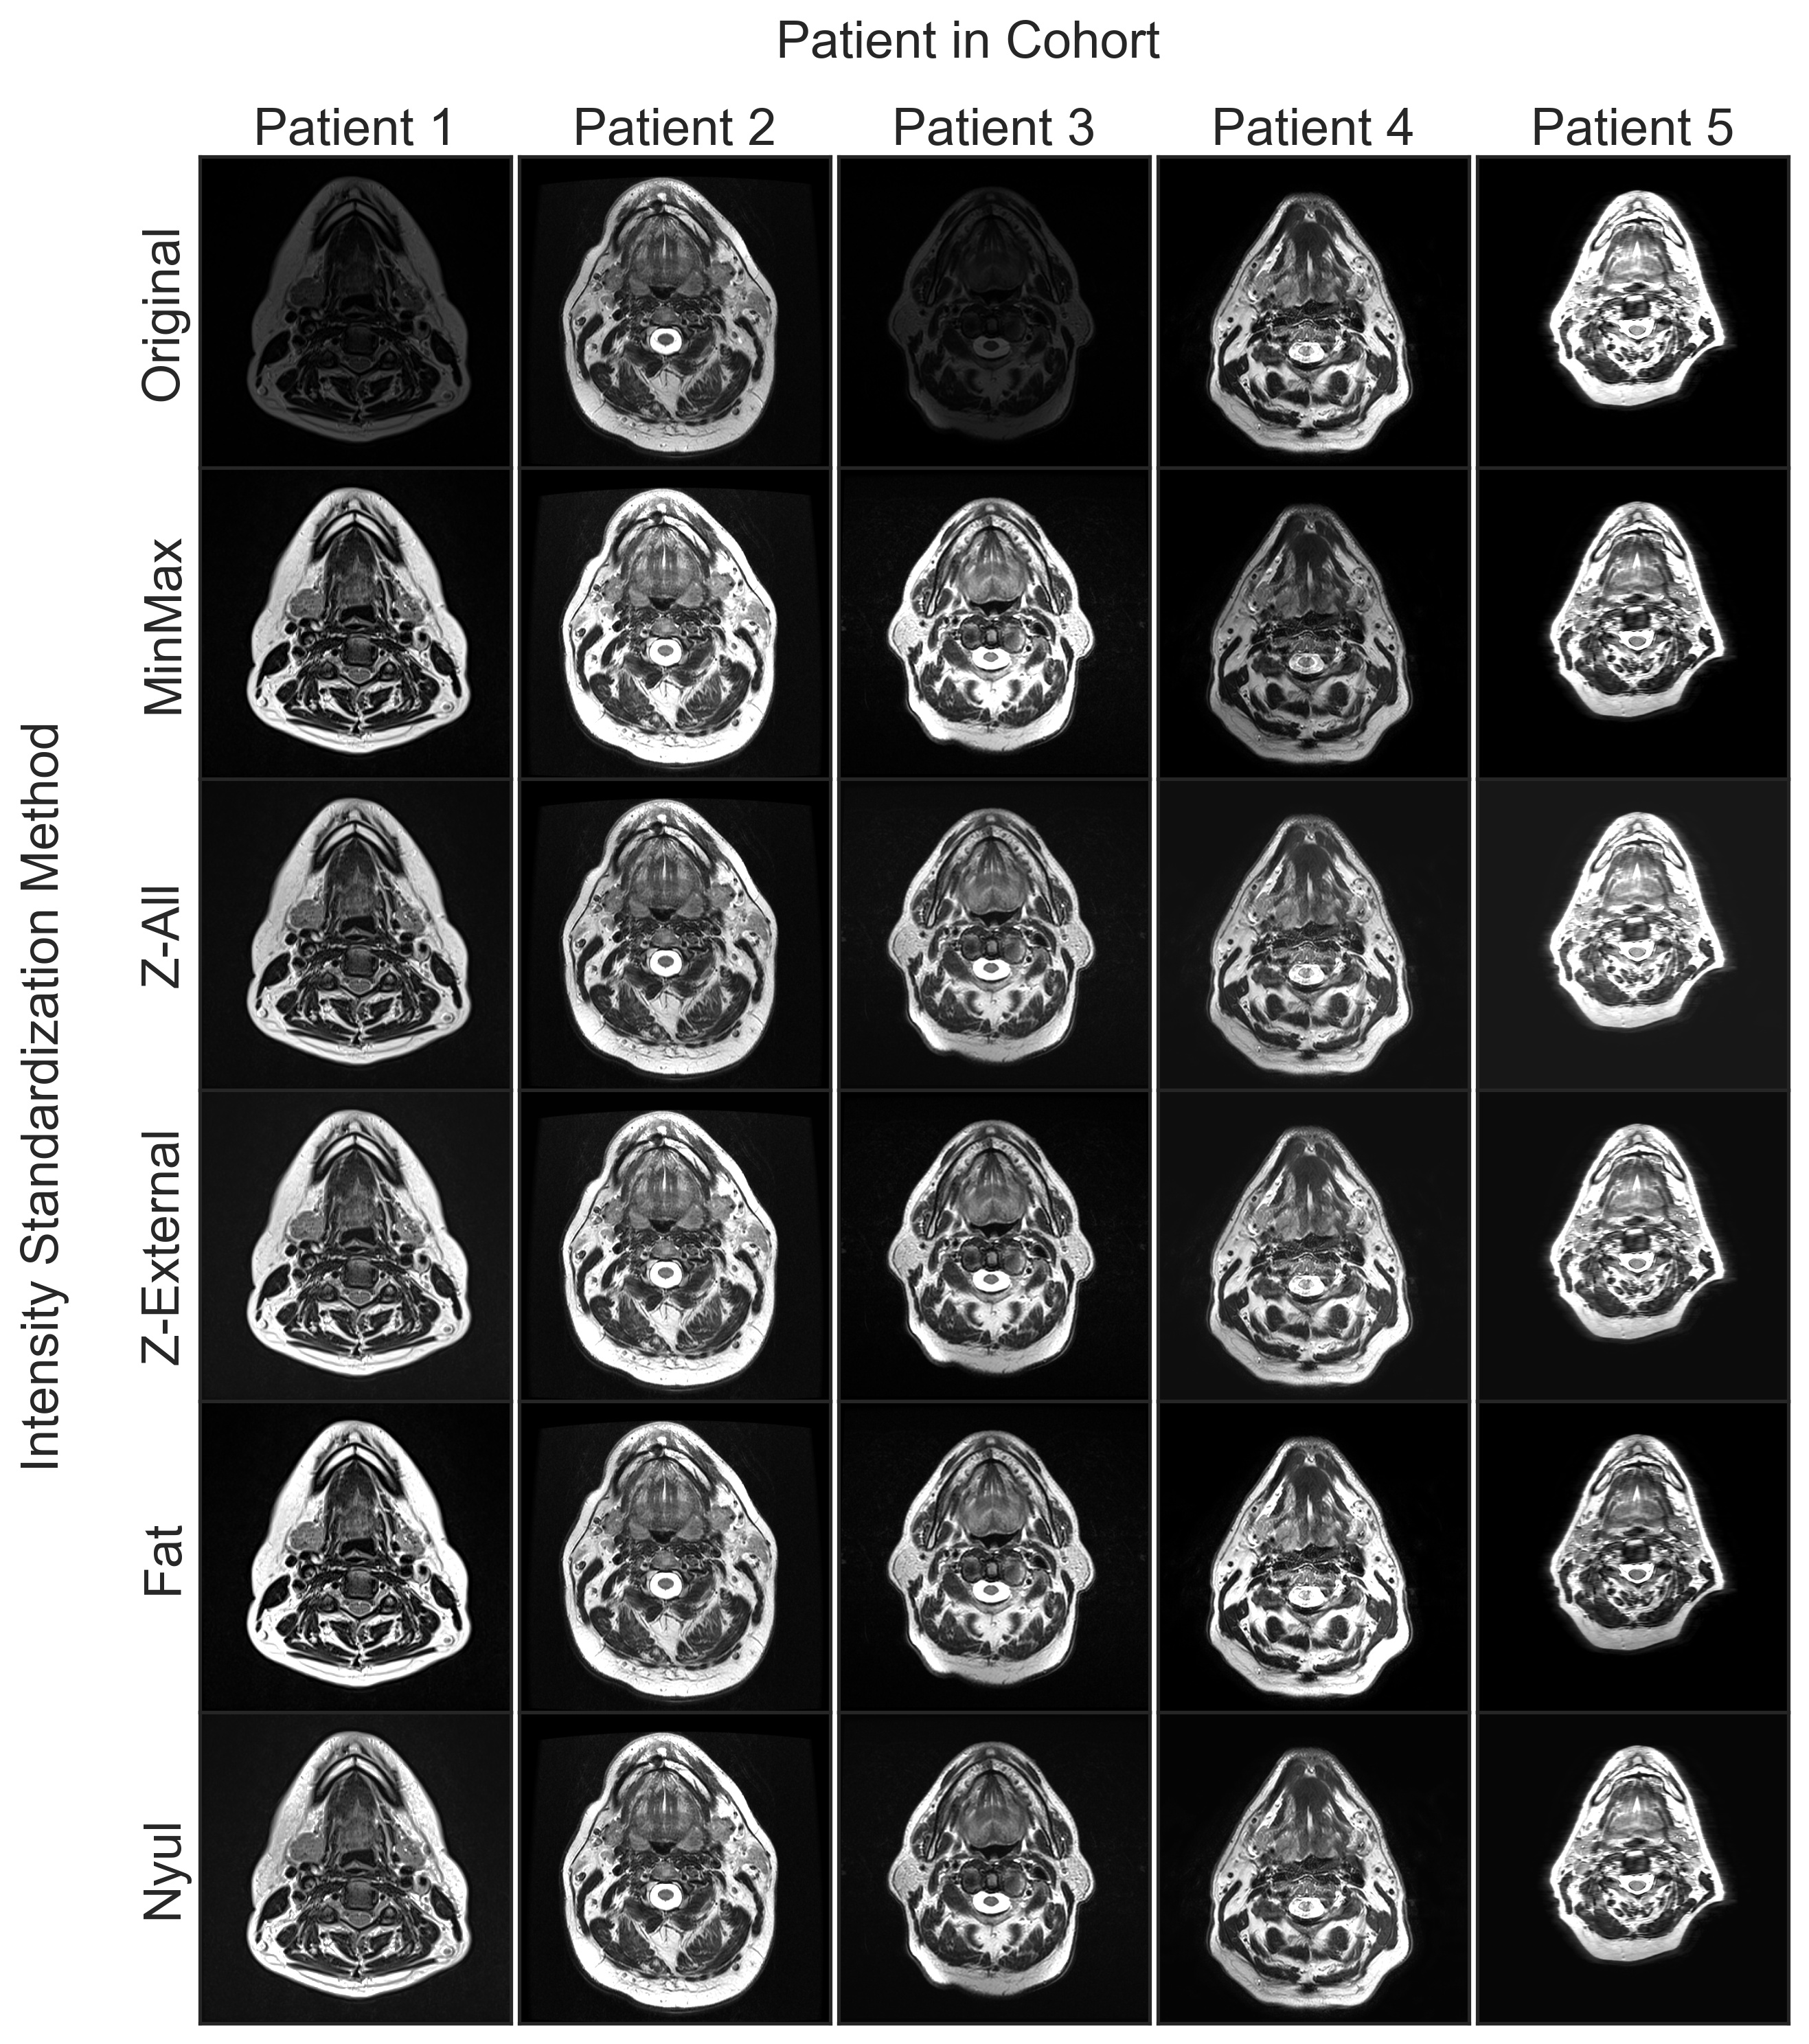

Wall time: 21.5 s


In [58]:
%%time
plot_paper_images(method_list_HET, df_image_new_HET, "HET")

In [19]:
tuple_list_HET = [x for x in tuple_list_HET if x[1] != "Fat_L" and x[1] != "Fat_R"] # remove cheek fat ROIs

In [20]:
%%time
df_HET = SDNMI_calc(method_list_HET, tuple_list_HET, df_image_new_HET, df_mask_HET)

Wall time: 3min 21s


Original 0.29 ± 0.08
MinMax 0.18 ± 0.03
Z-All 0.18 ± 0.04
Z-External 0.17 ± 0.04
Fat 0.18 ± 0.04
Nyul 0.17 ± 0.04


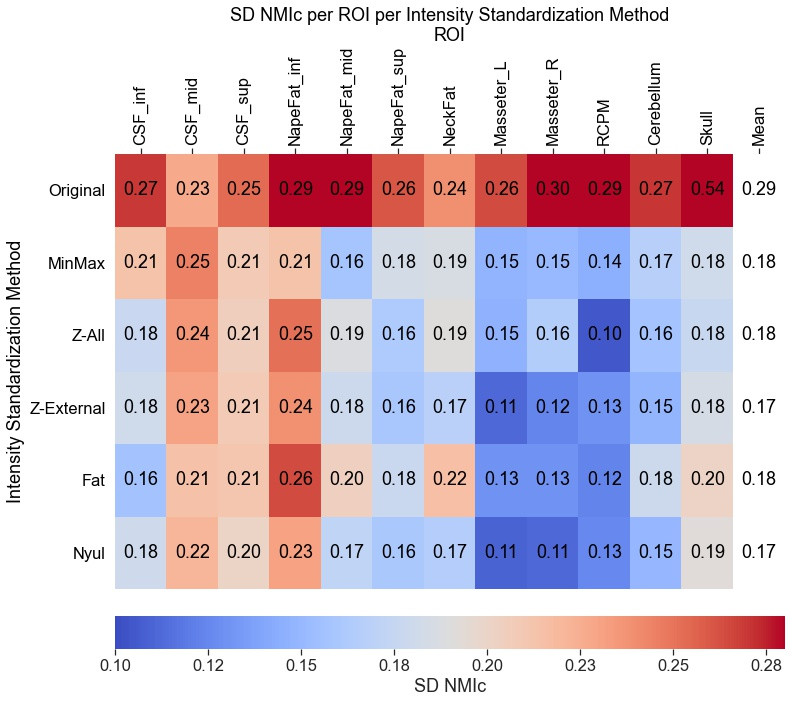

In [59]:
SDNMI_heatmap(method_list_HET, tuple_list_HET, df_HET)

In [22]:
pg.normality(df_HET, dv='SD_NMI', group='Method')

W      pval  normal
Original    0.581886  0.000076   False
MinMax      0.933234  0.415654    True
Z-All       0.969253  0.902824    True
Z-External  0.964697  0.848154    True
Fat         0.935339  0.440149    True
Nyul        0.960968  0.797556    True

In [23]:
pg.friedman(data=df_HET, dv='SD_NMI', within='Method', subject='ROI')

Source  ddof1          Q     p-unc
Friedman  Method      5  27.571429  0.000044

In [24]:
pairwise_ttests_HET = pairwise_ttests(data = df_HET, dv = "SD_NMI", subject = "ROI", within = "Method", padjust='bonf', parametric = False) # okay I think this is what you want

In [25]:
pairwise_ttests_HET

Contrast           A           B  Paired  Parametric  W-val       Tail  \
0    Method    Original      MinMax    True       False    1.0  two-sided   
1    Method    Original       Z-All    True       False    1.0  two-sided   
2    Method    Original  Z-External    True       False    1.0  two-sided   
3    Method    Original         Fat    True       False    0.0  two-sided   
4    Method    Original        Nyul    True       False    0.0  two-sided   
5    Method      MinMax       Z-All    True       False   30.0  two-sided   
6    Method      MinMax  Z-External    True       False   19.0  two-sided   
7    Method      MinMax         Fat    True       False   38.0  two-sided   
8    Method      MinMax        Nyul    True       False   10.0  two-sided   
9    Method       Z-All  Z-External    True       False   19.0  two-sided   
10   Method       Z-All         Fat    True       False   31.0  two-sided   
11   Method       Z-All        Nyul    True       False   17.0  two-sided   
12   Method  Z-External         Fat    True       False   15.0  two-sided   
13   Method  Z-External        Nyul    True       False   13.0  two-sided   
14   Method         Fat        Nyul    True       False   11.0  two-sided   

       p-unc    p-corr p-adjust    hedges  
0   0.000977  0.014648     bonf  1.673189  
1   0.000977  0.014648     bonf  1.666233  
2   0.000977  0.014648     bonf  1.775350  
3   0.000488  0.007324     bonf  1.579875  
4   0.000488  0.007324     bonf  1.835100  
5   0.518555  1.000000     bonf  0.086758  
6   0.129395  1.000000     bonf  0.296036  
7   0.969727  1.000000     bonf -0.019092  
8   0.020996  0.314941     bonf  0.398610  
9   0.129395  1.000000     bonf  0.191989  
10  0.569336  1.000000     bonf -0.092843  
11  0.092285  1.000000     bonf  0.284549  
12  0.063965  0.959473     bonf -0.275406  
13  0.042480  0.637207     bonf  0.090191  
14  0.026855  0.402832     bonf  0.364343

## HOM Cohort <a name="HOM"></a>
Code takes approx. 10 mins to run.

In [26]:
%%time
%%capture
ROI_list_HOM  = ['CSF_inf', 'CSF_mid', 'CSF_sup', 
            'Fat_L', 'Fat_R','NapeFat_inf', 'NapeFat_mid', 'NapeFat_sup','NeckFat',
            'Masseter_L', 'Masseter_R','RCPM',
            'Cerebellum', 
             'Skull',
             'External']  

path_HOM = os.path.join('.', 'HOM_cohort') # HOM cohort
path2_HOM = os.path.join('.', 'HOM_cohort_nyul')

method_list_HOM = ['Original', 'MinMax', 'Z-All', 'Z-External', 'Fat', 'Nyul']

tuple_list_HOM, fat_left_index_HOM, fat_right_index_HOM, external_index_HOM, df_image_HOM, df_mask_HOM = dicom_to_numpy(ROI_list_HOM, path_HOM, "T2")
df_image_new_HOM = standardization(method_list_HOM, df_image_HOM, df_mask_HOM, fat_left_index_HOM, fat_right_index_HOM, external_index_HOM, path2_HOM)

Wall time: 9min 23s


In [27]:
dicom_HOM_T2 = dicom_header_info(path_HOM, "T2")
dicom_HOM_T2 # display the dataframe 

SeriesDescription Manufacturer ManufacturerModelName  \
0             T2 TSE      SIEMENS                  Aera   
1             T2 TSE      SIEMENS                  Aera   
2             T2 TSE      SIEMENS                  Aera   
3             T2 TSE      SIEMENS                  Aera   
4             T2 TSE      SIEMENS                  Aera   
5             T2 TSE      SIEMENS                  Aera   
6             T2 TSE      SIEMENS                  Aera   
7             T2 TSE      SIEMENS                  Aera   
8             T2 TSE      SIEMENS                  Aera   
9             T2 TSE      SIEMENS                  Aera   
10            T2 TSE      SIEMENS                  Aera   
11            T2 TSE      SIEMENS                  Aera   
12            T2 TSE      SIEMENS                  Aera   
13            T2 TSE      SIEMENS                  Aera   
14            T2 TSE      SIEMENS                  Aera   

    MagneticFieldStrength  RepetitionTime  EchoTime EchoTrainLength  \
0                     1.5          4800.0      80.0              15   
1                     1.5          4800.0      80.0              15   
2                     1.5          4800.0      80.0              15   
3                     1.5          4800.0      80.0              15   
4                     1.5          4800.0      80.0              15   
5                     1.5          4800.0      80.0              15   
6                     1.5          4800.0      80.0              15   
7                     1.5          4800.0      80.0              15   
8                     1.5          4800.0      80.0              15   
9                     1.5          4800.0      80.0              15   
10                    1.5          4800.0      80.0              15   
11                    1.5          4800.0      80.0              15   
12                    1.5          4800.0      80.0              15   
13                    1.5          4800.0      80.0              15   
14                    1.5          4800.0      80.0              15   

    FlipAngle PixelSpacing  SliceThickness  SpacingBetweenSlices  \
0       180.0   [0.5, 0.5]             2.0                   2.0   
1       180.0   [0.5, 0.5]             2.0                   2.0   
2       180.0   [0.5, 0.5]             2.0                   2.0   
3       180.0   [0.5, 0.5]             2.0                   2.0   
4       180.0   [0.5, 0.5]             2.0                   2.0   
5       180.0   [0.5, 0.5]             2.0                   2.0   
6       180.0   [0.5, 0.5]             2.0                   2.0   
7       180.0   [0.5, 0.5]             2.0                   2.0   
8       180.0   [0.5, 0.5]             2.0                   2.0   
9       180.0   [0.5, 0.5]             2.0                   2.0   
10      180.0   [0.5, 0.5]             2.0                   2.0   
11      180.0   [0.5, 0.5]             2.0                   2.0   
12      180.0   [0.5, 0.5]             2.0                   2.0   
13      180.0   [0.5, 0.5]             2.0                   2.0   
14      180.0   [0.5, 0.5]             2.0                   2.0   

    ImagingFrequency  NumberOfAverages  PercentSampling AcquisitionMatrix  \
0          63.675912               1.0             90.0  [256, 0, 0, 230]   
1          63.675895               1.0             90.0  [256, 0, 0, 230]   
2          63.675926               1.0             90.0  [256, 0, 0, 230]   
3          63.675873               1.0             90.0  [256, 0, 0, 230]   
4          63.675921               1.0             90.0  [256, 0, 0, 230]   
5          63.675874               1.0             90.0  [256, 0, 0, 230]   
6          63.675877               1.0             90.0  [256, 0, 0, 230]   
7          63.675952               1.0             90.0  [256, 0, 0, 230]   
8          63.675934               1.0             90.0  [256, 0, 0, 230]   
9          63.675873               1.0             90.0  [256,

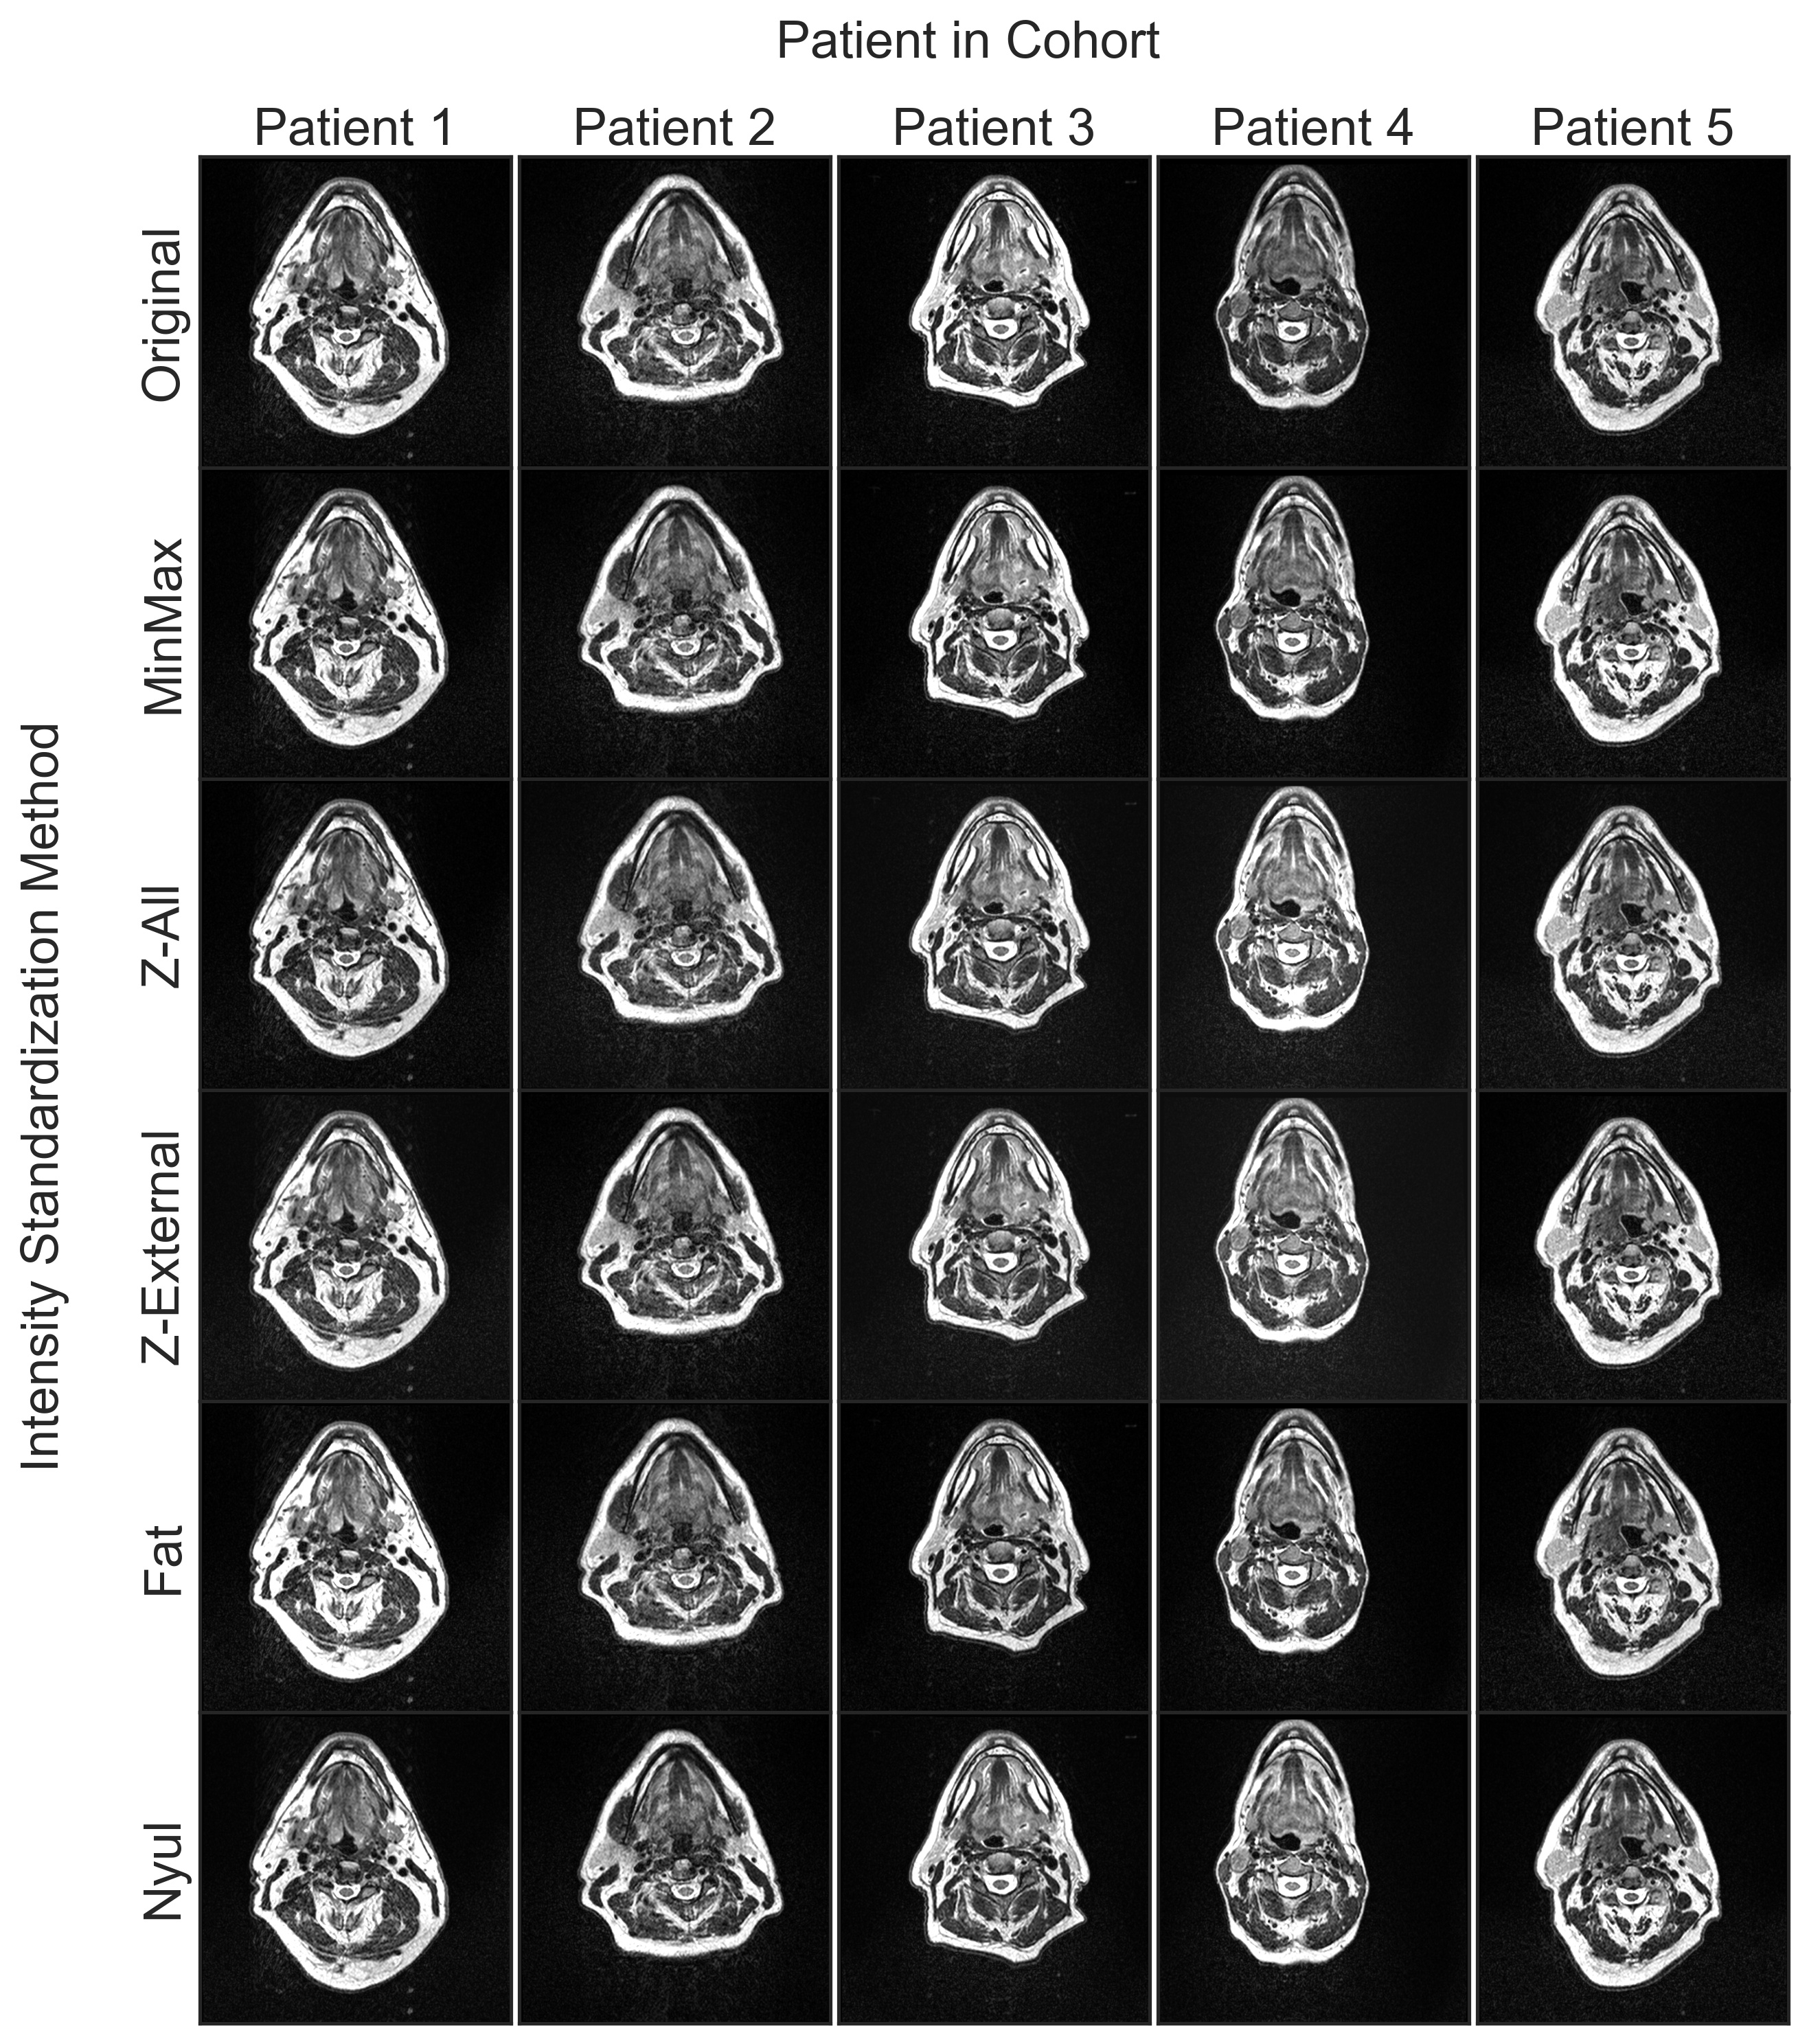

Wall time: 38.2 s


In [60]:
%%time
plot_paper_images(method_list_HOM, df_image_new_HOM, "HOM")

In [29]:
tuple_list_HOM = [x for x in tuple_list_HOM if x[1] != "Fat_L" and x[1] != "Fat_R"] # # remove cheek fat ROIs

In [30]:
%%time
df_HOM = SDNMI_calc(method_list_HOM, tuple_list_HOM, df_image_new_HOM, df_mask_HOM)

Wall time: 9min 4s


Original 0.15 ± 0.03
MinMax 0.18 ± 0.04
Z-All 0.16 ± 0.02
Z-External 0.13 ± 0.03
Fat 0.14 ± 0.03
Nyul 0.13 ± 0.03


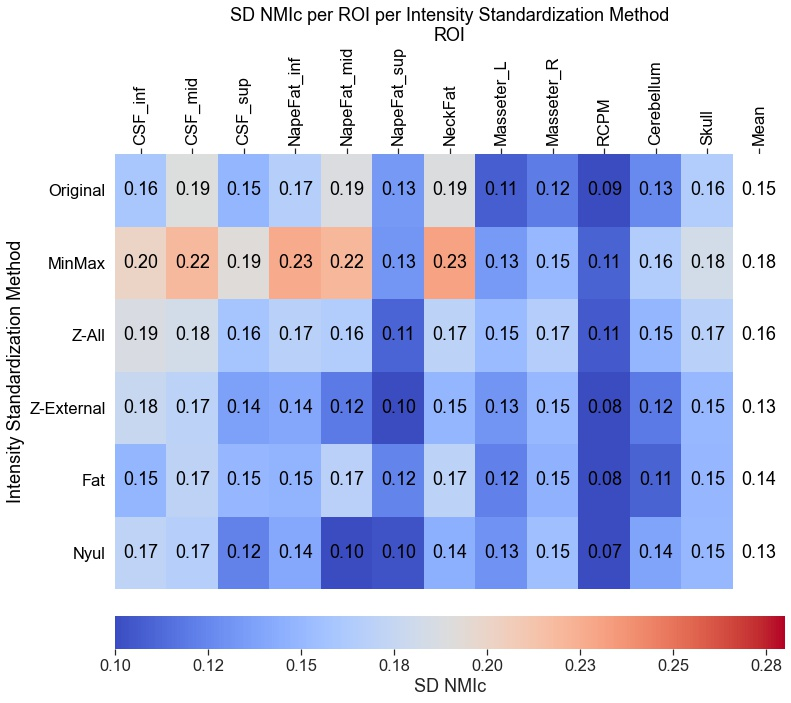

In [61]:
SDNMI_heatmap(method_list_HOM, tuple_list_HOM, df_HOM)

In [32]:
pg.normality(df_HOM, dv='SD_NMI', group='Method') # check for non-normal distributions 

W      pval  normal
Original    0.935759  0.445153    True
MinMax      0.928341  0.362859    True
Z-All       0.846423  0.033172   False
Z-External  0.961569  0.805976    True
Fat         0.893273  0.129873    True
Nyul        0.937686  0.468689    True

In [33]:
pg.friedman(data=df_HOM, dv='SD_NMI', within='Method', subject='ROI') # non-parametric analog to repeated measures ANOVA

Source  ddof1          Q     p-unc
Friedman  Method      5  33.238095  0.000003

In [34]:
pairwise_ttests_HOM = pairwise_ttests(data = df_HOM, dv = "SD_NMI", subject = "ROI", within = "Method", padjust='bonf', parametric = False) # okay I think this is what you want

In [35]:
pairwise_ttests_HOM

Contrast           A           B  Paired  Parametric  W-val       Tail  \
0    Method    Original      MinMax    True       False    1.0  two-sided   
1    Method    Original       Z-All    True       False   26.0  two-sided   
2    Method    Original  Z-External    True       False   21.0  two-sided   
3    Method    Original         Fat    True       False   18.0  two-sided   
4    Method    Original        Nyul    True       False   18.0  two-sided   
5    Method      MinMax       Z-All    True       False   10.0  two-sided   
6    Method      MinMax  Z-External    True       False    0.0  two-sided   
7    Method      MinMax         Fat    True       False    0.0  two-sided   
8    Method      MinMax        Nyul    True       False    2.0  two-sided   
9    Method       Z-All  Z-External    True       False    0.0  two-sided   
10   Method       Z-All         Fat    True       False    8.0  two-sided   
11   Method       Z-All        Nyul    True       False    0.0  two-sided   
12   Method  Z-External         Fat    True       False   29.0  two-sided   
13   Method  Z-External        Nyul    True       False   29.0  two-sided   
14   Method         Fat        Nyul    True       False   29.0  two-sided   

       p-unc    p-corr p-adjust    hedges  
0   0.000977  0.014648     bonf -0.812011  
1   0.339355  1.000000     bonf -0.260098  
2   0.176270  1.000000     bonf  0.439988  
3   0.109863  1.000000     bonf  0.258613  
4   0.109863  1.000000     bonf  0.495826  
5   0.020996  0.314941     bonf  0.665307  
6   0.000488  0.007324     bonf  1.238802  
7   0.000488  0.007324     bonf  1.094084  
8   0.001465  0.021973     bonf  1.269370  
9   0.000488  0.007324     bonf  0.792406  
10  0.012207  0.183105     bonf  0.593612  
11  0.000488  0.007324     bonf  0.838608  
12  0.469727  1.000000     bonf -0.208576  
13  0.469727  1.000000     bonf  0.076173  
14  0.469727  1.000000     bonf  0.278044

## P-Value Heatmap <a name="pval"></a>

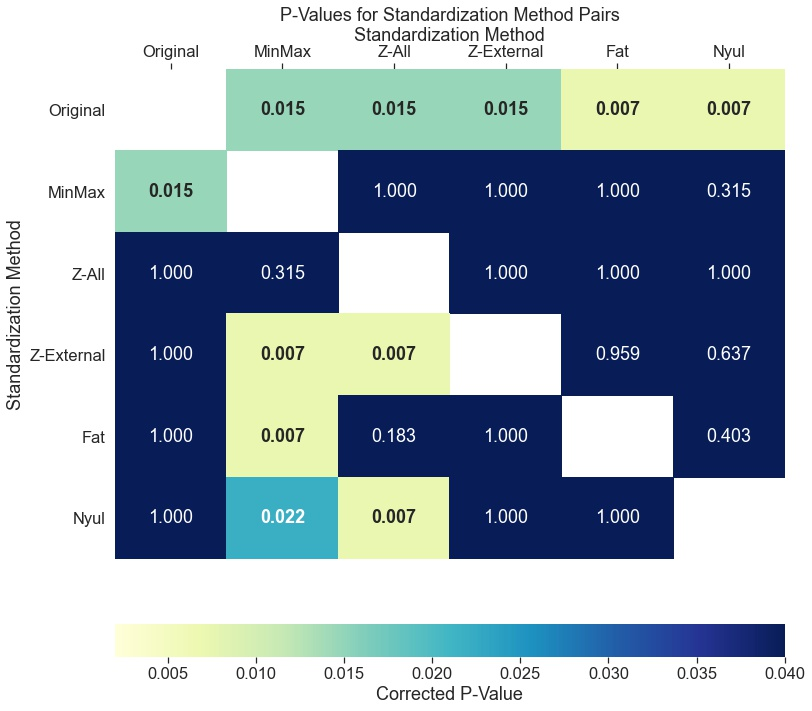

In [62]:
method_list = ['Original','MinMax', 'Z-All', 'Z-External', 'Fat', 'Nyul']

stats_heatmap_df = pd.DataFrame(index = method_list, columns = method_list)

for col in method_list:
    for row in method_list:
        if col == row:
            stats_heatmap_df.at[row, col] = "NaN"
        else:
            try: # error handeling if rows and cols don't match up, due to inherent structure of above 
                p_val = pairwise_ttests_HOM[(pairwise_ttests_HOM['A'] == col) & (pairwise_ttests_HOM['B'] == row)].iloc[0]['p-corr']
            except: 
                p_val = pairwise_ttests_HET[(pairwise_ttests_HET['A'] == row) & (pairwise_ttests_HET['B'] == col)].iloc[0]['p-corr']
            stats_heatmap_df.at[row, col] = p_val
            
stats_heatmap_df = stats_heatmap_df.astype(float)

fig, ax = plt.subplots(1, 1, figsize =(12,12))

heatmap = sns.heatmap(stats_heatmap_df, cmap="YlGnBu", annot= True, fmt=".3f", vmin = 0.002, vmax = 0.04,
                     cbar_kws = dict(pad=0.1, use_gridspec=False,location="bottom", label =  'Corrected P-Value', format = '%.3f'))
heatmap.set(xlabel='Standardization Method', ylabel='Standardization Method', title ='P-Values for Standardization Method Pairs')

for text in heatmap.texts: # make p < 0.05 bold
    try:
        if float(text.get_text()) <= 0.05:
            text.set_weight('bold')
    except:
        continue

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.yticks(rotation=0);
#plt.savefig('p_heatmap_new_v2.svg', bbox_inches='tight') # save vector based for adding borders in Illustrator 

# Supplementary Data <a name="appendix"></a>

In [37]:
sns.set(font_scale=1) # for plotting 
sns.set_style("white")
plt.rcParams['figure.figsize'] = (6, 4) # change back to default size 
#%config InlineBackend.figure_format = 'png' # for medium quality figure print outs
%config InlineBackend.figure_format = 'jpeg' # for low quality figure print outs

## Additional Functions <a name="functions2"></a>

In [38]:
def plot_histograms(method_list, tuple_list_2, df_image_new, df_mask, MRN_subset = ["1", "2", "3", "4", "5"]):
    """
    Generate plots of ROI intensity histograms for all patients in a given cohort stratified by tissue type.  
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            tuple_list_2 ((str,int,str)): List of tuples corresponding to pairs of ROI names, ROI indexes, and ROI categories.
            df_image_new (pd dataframe): Dataframe with rows corresponding to np arrays of unique patient method combinations. 
            df_mask (pd dataframe): Dataframe with rows corresponding to unique patients, columns containing np array of mask, patient identifier, and modality. 
            MRN_subset (lst): List of strings corresponding to patinet MRN IDs you want displayed in the histogram.
        Returns:
            None (generates in-line plots). 
    """
    df_image_new = df_image_new[df_image_new['MRN'].isin(MRN_subset)] # select subset 
    df_mask = df_mask[df_mask['MRN'].isin(MRN_subset)] # select subset
    
    method_list = method_list.copy()
    tissue_list = sorted(list(set([tuple[2] for tuple in tuple_list_2])))
    for tissue in tissue_list:
        counter_ROI = -1
        fig, ax = plt.subplots(nrows=len([tup for tup in tuple_list_2 if tup[2] == tissue]), ncols=len(method_list), squeeze=False, figsize=(20,10)) 
        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        for tup in tuple_list_2:
            if tup[2] == tissue:
                counter_ROI +=1
                counter_method = -1
                index = tup[0]
                roi = tup[1]
                for method in method_list:
                    counter_method+=1
                    df_new = df_image_new.loc[df_image_new['Normalization'] == method]
                    for modality, MRN, image, mask in zip(df_new['Modality'], df_new['MRN'], df_new['image_array'], df_mask['mask_array']):
                        image = image + 10000 # accounting for 0's in CT # dont need for zed score I think?
                        mask = convert_array(mask, index)
                        mask_superimposed = np.multiply(mask,image)
                        mask_superimposed[mask_superimposed==0] = 20000
                        mask_superimposed[mask_superimposed!= 20000] -= 10000 # accounting for 0's in CT
                        mask_superimposed_no0 = mask_superimposed[mask_superimposed != 20000] # purley for plotting purposes, had to do to plot 0's for CT
                        ax[counter_ROI][counter_method].hist(mask_superimposed_no0.flatten(), bins = 25, density = True, alpha = 0.75, log = False, histtype= 'step', label = MRN) 
                        ax[counter_ROI][counter_method].set_title(method + ' ' + modality +' ' + roi)

            else:
                continue
        plt.suptitle(tissue)
        plt.show()

In [39]:
def plot_all_images(method_list, df_image_new):
    """
    Generate plots of image slices across z-axis for each patient for each itensity standardization method. 
        Parameters:
            method_list (lst): List of strings corresponding to which standardization methods should be called.
            df_image_new (pd dataframe): Dataframe with rows corresponding to np arrays of unique patient method combinations.  
        Returns:
            None (generates in-line plots). 
    """
    method_list = method_list.copy()
    for method in method_list:
        df_new = df_image_new.loc[df_image_new['Normalization'] == method]
        image_list = [image for image in df_new['image_array']]
        image_list_flatten = [image.flatten() for image in image_list]
        all_images = np.concatenate(image_list_flatten)
        all_min = np.amin(all_images)
        all_max = np.amax(all_images)
        all_max_percentile = np.percentile(all_images,98)
        fig, ax = plt.subplots(5,13, figsize=[24,12], dpi=100, gridspec_kw = {'wspace':0, 'hspace':0})
        counter = -1
        for image in image_list:
            counter+=1
            image = np.moveaxis(image,0,-1)
            n = 0
            slice = 0
            total_slices = image.shape[2]
            for _ in range(13):
                ax[counter][n].imshow(image[:,:,floor(slice)], 'gray', vmin = all_min, vmax = all_max_percentile) 
                ax[counter][n].set_xticks([])
                ax[counter][n].set_yticks([])
                ax[counter][n].set_title("Slice: {}".format(floor(slice)), color = 'r') 
                ax[counter][n].set_aspect("equal")
                if n == 0:
                    ax[counter][n].set_ylabel("Patient " +str(counter+1)) 
                n+=1
                if n == 12: # neccessary to get the last slice for 120 slices
                    slice+=(total_slices/12)-1
                else:
                    slice+=(total_slices/12) 
                fig.subplots_adjust(wspace=0, hspace=0)
        fig.suptitle(method)
        plt.show()

## T2-w histogram data <a name="T2"></a>
For subset of 5 patients.

In [68]:
#plot_histograms(method_list_HET, tuple_list_HET, df_image_new_HET, df_mask_HET)

In [67]:
#plot_histograms(method_list_HOM, tuple_list_HOM, df_image_new_HOM, df_mask_HOM)

## T1-w Dixon data (histograms, images, SD NMIc) <a name="T1"></a>
For subset of 5 patients from HOM cohort.

In [42]:
%%time
%%capture
ROI_list_T1  = ['Parotid_L', 'Parotid_R', 
            'Fat_L', 'Fat_R','NapeFat_inf', 'NapeFat_mid', 'NapeFat_sup','NeckFat',
             'External']

path_T1 = os.path.join('.', 'HOM_cohort') # HOM cohort
path2_T1 = os.path.join('.', 'HOM_cohort_nyul')

method_list_T1 = ['Original', 'MinMax', 'Z-All', 'Z-External', 'Fat', 'Nyul']

tuple_list_T1, fat_left_index_T1, fat_right_index_T1, external_index_T1, df_image_T1, df_mask_T1 = dicom_to_numpy(ROI_list_T1, path_T1, "Dixon_F")
df_image_new_T1 = standardization(method_list_T1, df_image_T1, df_mask_T1, fat_left_index_T1, fat_right_index_T1, external_index_T1, path2_T1)

Wall time: 1min 30s


In [43]:
dicom_HOM_T1 = dicom_header_info(path_HOM, "Dixon_F")
dicom_HOM_T1 # display the dataframe 

SeriesDescription Manufacturer ManufacturerModelName  \
0     Ax 3D T1 Dixon_W      SIEMENS                  Aera   
1  +C Ax 3D T1 Dixon_W      SIEMENS                  Aera   
2     Ax 3D T1 Dixon_W      SIEMENS                  Aera   
3  +C Ax 3D T1 Dixon_W      SIEMENS                  Aera   
4  +C Ax 3D T1 Dixon_F      SIEMENS                  Aera   

   MagneticFieldStrength  RepetitionTime  EchoTime EchoTrainLength  FlipAngle  \
0                    1.5            7.11      2.39               2       10.0   
1                    1.5            7.11      2.39               2       10.0   
2                    1.5            7.11      2.39               2       10.0   
3                    1.5            7.11      2.39               2       10.0   
4                    1.5            7.11      2.39               2       10.0   

  PixelSpacing  SliceThickness  ImagingFrequency  NumberOfAverages  \
0       [1, 1]             1.0         63.675910               2.0   
1       [1, 1]             1.0         63.675971               2.0   
2       [1, 1]             1.0         63.675922               2.0   
3       [1, 1]             1.0         63.675908               2.0   
4       [1, 1]             1.0         63.675907               2.0   

   PercentSampling  PixelBandwidth AcquisitionMatrix PixelRepresentation  
0            100.0           405.0  [256, 0, 0, 256]                   0  
1            100.0           405.0  [256, 0, 0, 256]                   0  
2            100.0           405.0  [256, 0, 0, 256]                   0  
3            100.0           405.0  [256, 0, 0, 256]                   0  
4            100.0           405.0  [256, 0, 0, 256]                   0

In [44]:
df_T1 = SDNMI_calc(method_list_T1, tuple_list_T1, df_image_new_T1, df_mask_T1)

Original 0.13 ± 0.05
MinMax 0.12 ± 0.05
Z-All 0.12 ± 0.03
Z-External 0.10 ± 0.03
Fat 0.10 ± 0.05
Nyul 0.09 ± 0.02


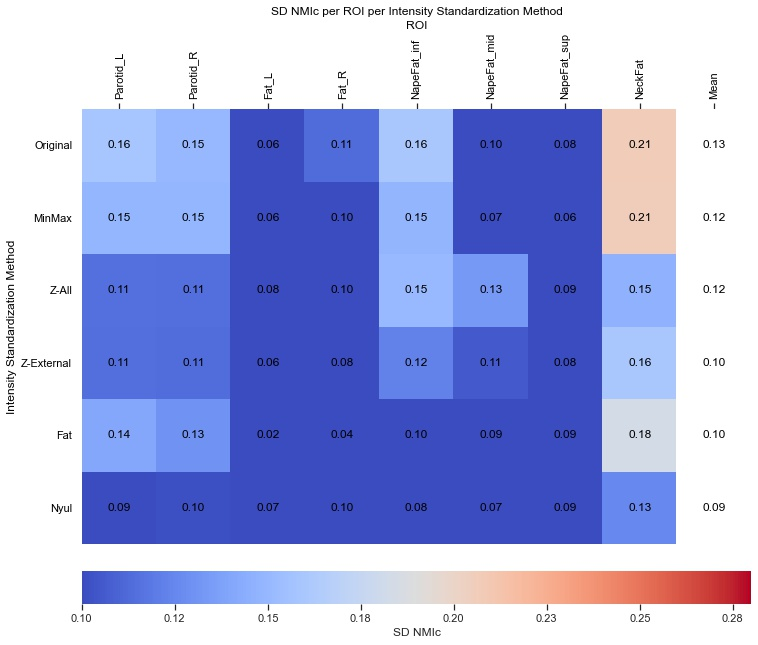

In [45]:
SDNMI_heatmap(method_list_T1, tuple_list_T1, df_T1)

In [46]:
pg.friedman(data=df_T1, dv='SD_NMI', within='Method', subject='ROI')

Source  ddof1          Q     p-unc
Friedman  Method      5  10.214286  0.069386

In [66]:
#plot_histograms(method_list_T1, tuple_list_T1, df_image_new_T1, df_mask_T1)

In [64]:
#plot_all_images(method_list_T1, df_image_new_T1)

## CT data (histograms, images, SD NMIc) <a name="CT"></a>
For subset of 5 patients from HOM cohort.

In [49]:
%%time
%%capture
ROI_list_CT  = ['CSF_inf', 'CSF_mid', 'CSF_sup', 
            'Fat_L', 'Fat_R','NapeFat_inf', 'NapeFat_mid', 'NapeFat_sup','NeckFat',
            'Masseter_L', 'Masseter_R','RCPM',
            'Cerebellum', 
             'Skull',
             'External']  

path_CT = os.path.join('.', 'HOM_cohort') # HOM cohort
path2_CT = os.path.join('.', 'HOM_cohort_nyul') 

method_list_CT = ['Original', 'MinMax', 'Z-All', 'Z-External', 'Fat', 'Nyul']

tuple_list_CT, fat_left_index_CT, fat_right_index_CT, external_index_CT, df_image_CT, df_mask_CT = dicom_to_numpy(ROI_list_CT, path_CT, "CT")
df_image_new_CT = standardization(method_list_CT, df_image_CT, df_mask_CT, fat_left_index_CT, fat_right_index_CT, external_index_CT, path2_CT)

Wall time: 6min 5s


In [50]:
dicom_HOM_CT = dicom_header_info(path_HOM, "CT")
dicom_HOM_CT # display the dataframe 

SeriesDescription Manufacturer    ManufacturerModelName  \
0     Head and Neck      SIEMENS  SOMATOM Definition Edge   
1     Head and Neck      SIEMENS  SOMATOM Definition Edge   
2     Head and Neck      SIEMENS  SOMATOM Definition Edge   
3                        Philips      Brilliance Big Bore   
4             O-MAR      Philips      Brilliance Big Bore   

               PixelSpacing  SliceThickness Rows Columns    KVP  \
0    [0.9765625, 0.9765625]             2.0  512     512  120.0   
1    [0.9765625, 0.9765625]             2.0  512     512  120.0   
2    [0.9765625, 0.9765625]             2.0  512     512  120.0   
3      [1.171875, 1.171875]             3.0  512     512  120.0   
4  [1.03515625, 1.03515625]             3.0  512     512  120.0   

  ConvolutionKernel  
0              B40s  
1              B40s  
2              B40s  
3                 B  
4                UB

In [51]:
df_CT = SDNMI_calc(method_list_CT, tuple_list_CT, df_image_new_CT, df_mask_CT)

Original 0.09 ± 0.03
MinMax 0.11 ± 0.04
Z-All 0.28 ± 0.06
Z-External 0.14 ± 0.04
Fat 0.20 ± 0.06
Nyul 0.14 ± 0.04


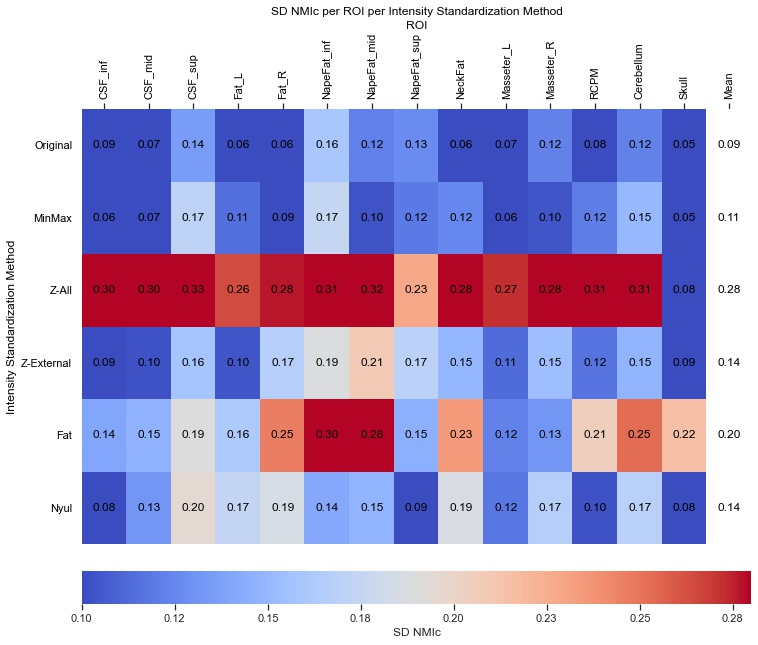

In [52]:
SDNMI_heatmap(method_list_CT, tuple_list_CT, df_CT)

In [53]:
pg.friedman(data=df_CT, dv='SD_NMI', within='Method', subject='ROI')

Source  ddof1          Q         p-unc
Friedman  Method      5  50.040816  1.359400e-09

In [54]:
pairwise_ttests(data = df_CT, dv = "SD_NMI", subject = "ROI", within = "Method", padjust='bonf', parametric = False) 

Contrast           A           B  Paired  Parametric  W-val       Tail  \
0    Method    Original      MinMax    True       False   31.0  two-sided   
1    Method    Original       Z-All    True       False    0.0  two-sided   
2    Method    Original  Z-External    True       False    0.0  two-sided   
3    Method    Original         Fat    True       False    0.0  two-sided   
4    Method    Original        Nyul    True       False    9.0  two-sided   
5    Method      MinMax       Z-All    True       False    0.0  two-sided   
6    Method      MinMax  Z-External    True       False   10.0  two-sided   
7    Method      MinMax         Fat    True       False    0.0  two-sided   
8    Method      MinMax        Nyul    True       False   15.0  two-sided   
9    Method       Z-All  Z-External    True       False    1.0  two-sided   
10   Method       Z-All         Fat    True       False    9.0  two-sided   
11   Method       Z-All        Nyul    True       False    0.0  two-sided   
12   Method  Z-External         Fat    True       False    5.0  two-sided   
13   Method  Z-External        Nyul    True       False   47.0  two-sided   
14   Method         Fat        Nyul    True       False    9.0  two-sided   

       p-unc    p-corr p-adjust    hedges  
0   0.193726  1.000000     bonf -0.329221  
1   0.000122  0.001831     bonf -3.532212  
2   0.000122  0.001831     bonf -1.170919  
3   0.000122  0.001831     bonf -2.060775  
4   0.004028  0.060425     bonf -1.136844  
5   0.000122  0.001831     bonf -3.170555  
6   0.005249  0.078735     bonf -0.782260  
7   0.000122  0.001831     bonf -1.741538  
8   0.016602  0.249023     bonf -0.768499  
9   0.000244  0.003662     bonf  2.617270  
10  0.004028  0.060425     bonf  1.255776  
11  0.000122  0.001831     bonf  2.539633  
12  0.001221  0.018311     bonf -1.154935  
13  0.760864  1.000000     bonf -0.018056  
14  0.004028  0.060425     bonf  1.111602

In [65]:
#plot_histograms(method_list_CT, tuple_list_CT, df_image_new_CT, df_mask_CT)

In [63]:
#plot_all_images(method_list_CT, df_image_new_CT)